# House Sales in King County, USA

A dataset from [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) containing prices of houses is provided.

We want to build a  model that can determine the prices of a given house according to a number of features. We will use a subset of the data for training and the remaining for testing our modeling.

## Outline

We separate the project in 3 steps:

**Data Loading and Exploratory Data Analysis:** Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

**Feature Engineering / Modeling:** Once we have the data, we create some features and then the modeling stage begins, making use of different models with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

**Results and Conclusions:** Finally, with our tuned model, we  predict against the test set, then we review those results against their actual values to determine the performance of the model, and finally, outline our conclusions.

In [1]:
library(caret)
library(GGally)
library(leaflet)
library(ggplot2)
library(geosphere)
library(IRdisplay)
library(lubridate)
library(gridExtra)
library(doParallel)
library(data.table)
library(htmlwidgets)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
“replacing previous import ‘ggplot2::empty’ by ‘plyr::empty’ when loading ‘caret’”Warning message:
“replacing previous import ‘ggplot2::empty’ by ‘plyr::empty’ when loading ‘GGally’”
Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year



### Setting up the cluster to run in parallel

This will optimize model training times

In [2]:
cluster <- makeCluster(detectCores() - 1)
registerDoParallel(cluster)

### Setting Seed

We specify a seed value to ensure reproducibility

In [3]:
set.seed(1000)

### Data Loading

Here we load the necessary data from Github Gists, describe its contents and print its first rows.

In [4]:
dt<-fread('https://gist.githubusercontent.com/akoury/476544de6703b7376c3ffe62ac242582/raw/ddcc3ec0e2d4a9fdeef0e44407377bb2aa5f2a9b/house.csv')
dt$date<-format(as.Date(dt$date, format = "%Y%m%d"), "%m/%d/%Y")

trainIndex <- createDataPartition(dt$price, p = .8, list = FALSE, times = 1)

train <- dt[ trainIndex,]
test  <- dt[-trainIndex,]

In [5]:
str(train)

Classes ‘data.table’ and 'data.frame':	17292 obs. of  21 variables:
 $ id           :integer64 6414100192 5631500400 2487200875 1954400510 7237550310 1321400060 2008000270 2414600126 ... 
 $ date         : chr  "12/09/2014" "02/25/2015" "12/09/2014" "02/18/2015" ...
 $ price        : num  538000 180000 604000 510000 1225000 ...
 $ bedrooms     : int  3 2 4 3 4 3 3 3 3 3 ...
 $ bathrooms    : num  2.25 1 3 2 4.5 2.25 1.5 1 2.5 2.5 ...
 $ sqft_living  : int  2570 770 1960 1680 5420 1715 1060 1780 1890 3560 ...
 $ sqft_lot     : int  7242 10000 5000 8080 101930 6819 9711 7470 6560 9796 ...
 $ floors       : num  2 1 1 1 1 2 1 1 2 1 ...
 $ waterfront   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : int  3 3 5 3 3 3 3 3 3 3 ...
 $ grade        : int  7 6 7 8 11 7 7 7 7 8 ...
 $ sqft_above   : int  2170 770 1050 1680 3890 1715 1060 1050 1890 1860 ...
 $ sqft_basement: int  400 0 910 0 1530 0 0 730 0 1700 ...
 $ yr_built     : int  1951 1933 19

In [6]:
summary(train)

       id                 date               price            bedrooms     
 Min.   :   1000102   Length:17292       Min.   :  75000   Min.   : 0.000  
 1st Qu.:2131701020   Class :character   1st Qu.: 321838   1st Qu.: 3.000  
 Median :3905080280   Mode  :character   Median : 450000   Median : 3.000  
 Mean   :4595678276                      Mean   : 539982   Mean   : 3.369  
 3rd Qu.:7334501250                      3rd Qu.: 645000   3rd Qu.: 4.000  
 Max.   :9900000190                      Max.   :7700000   Max.   :33.000  
   bathrooms      sqft_living       sqft_lot           floors    
 Min.   :0.000   Min.   :  290   Min.   :    520   Min.   :1.00  
 1st Qu.:1.750   1st Qu.: 1430   1st Qu.:   5040   1st Qu.:1.00  
 Median :2.250   Median : 1910   Median :   7587   Median :1.50  
 Mean   :2.112   Mean   : 2075   Mean   :  14987   Mean   :1.49  
 3rd Qu.:2.500   3rd Qu.: 2540   3rd Qu.:  10630   3rd Qu.:2.00  
 Max.   :8.000   Max.   :12050   Max.   :1651359   Max.   :3.50  
   wat

In [7]:
head(train)

id         date       price   bedrooms bathrooms sqft_living sqft_lot floors
1 6414100192 12/09/2014  538000 3        2.25      2570          7242   2     
2 5631500400 02/25/2015  180000 2        1.00       770         10000   1     
3 2487200875 12/09/2014  604000 4        3.00      1960          5000   1     
4 1954400510 02/18/2015  510000 3        2.00      1680          8080   1     
5 7237550310 05/12/2014 1225000 4        4.50      5420        101930   1     
6 1321400060 06/27/2014  257500 3        2.25      1715          6819   2     
  waterfront view ⋯ grade sqft_above sqft_basement yr_built yr_renovated
1 0          0    ⋯  7    2170        400          1951     1991        
2 0          0    ⋯  6     770          0          1933        0        
3 0          0    ⋯  7    1050        910          1965        0        
4 0          0    ⋯  8    1680          0          1987        0        
5 0          0    ⋯ 11    3890       1530          2001        0        
6 0          0    ⋯  7    1715          0          1995        0        
  zipcode lat     long     sqft_living15 sqft_lot15
1 98125   47.7210 -122.319 1690            7639    
2 98028   47.7379 -122.233 2720            8062    
3 98136   47.5208 -122.393 1360            5000    
4 98074   47.6168 -122.045 1800            7503    
5 98053   47.6561 -122.005 4760          101930    
6 98003   47.3097 -122.327 2238            6819

### Missing Data

We check if there is any missing data per column.

In [8]:
sapply(train, function(x) sum(is.na(x)))

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15 
            0

### Checking Duplicated Values

In [9]:
any(duplicated(train))

[1] FALSE

### Converting column types
Now we convert the data types of multiple columns.

#### Numericals

In [10]:
train[ , which(sapply(train, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(train, is.integer)]
test[ , which(sapply(test, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(test, is.integer)]

#### Dates
We extract the year, month and days since posting

In [11]:
train$date<-mdy(train$date)
train$year<-year(train$date)
train$month<-month(train$date)
train$days_since<-as.numeric(Sys.Date() - train$date)

test$date<-mdy(test$date)
test$year<-year(test$date)
test$month<-month(test$date)
test$days_since<-as.numeric(Sys.Date() - test$date)

### Dropping unneeded columnss
Now we drop unneeded columns.

In [12]:
train[, c('id','date'):=NULL]
test[, c('date'):=NULL]

## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

### Distribution of Apartment Prices

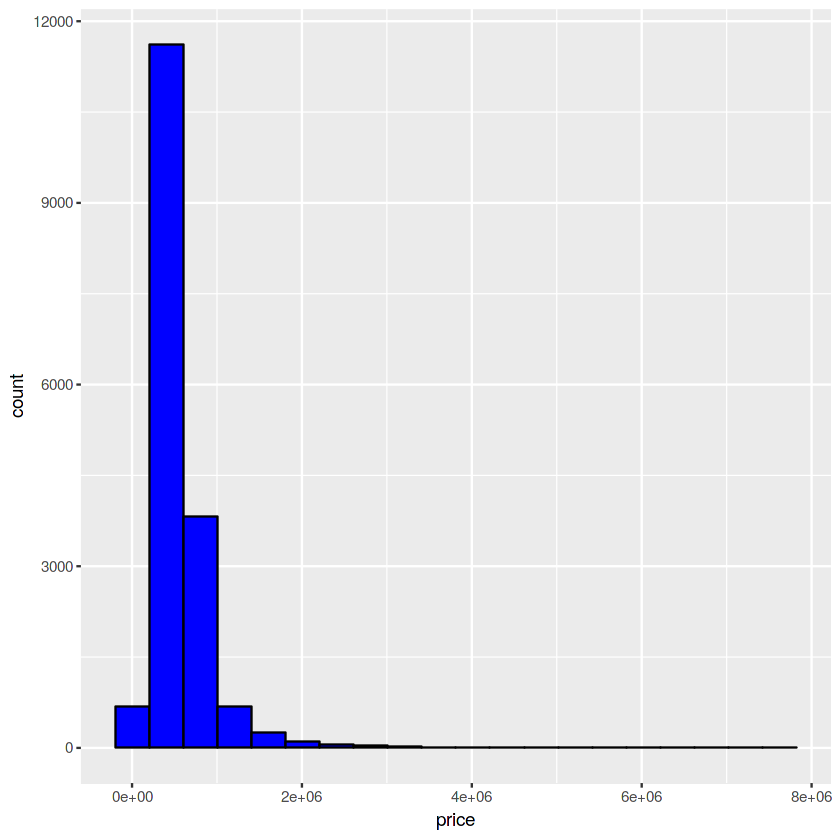

In [13]:
ggplot(train, aes(x=price))+ geom_histogram(bins=20, colour="black", fill="blue")

### Pair plots of each feature vs Price

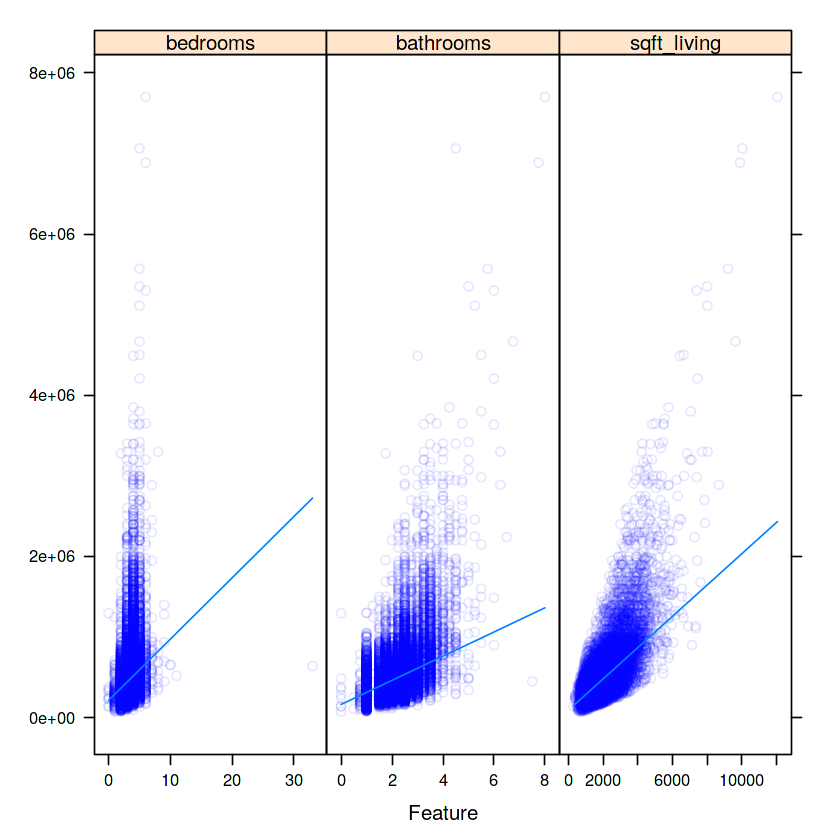

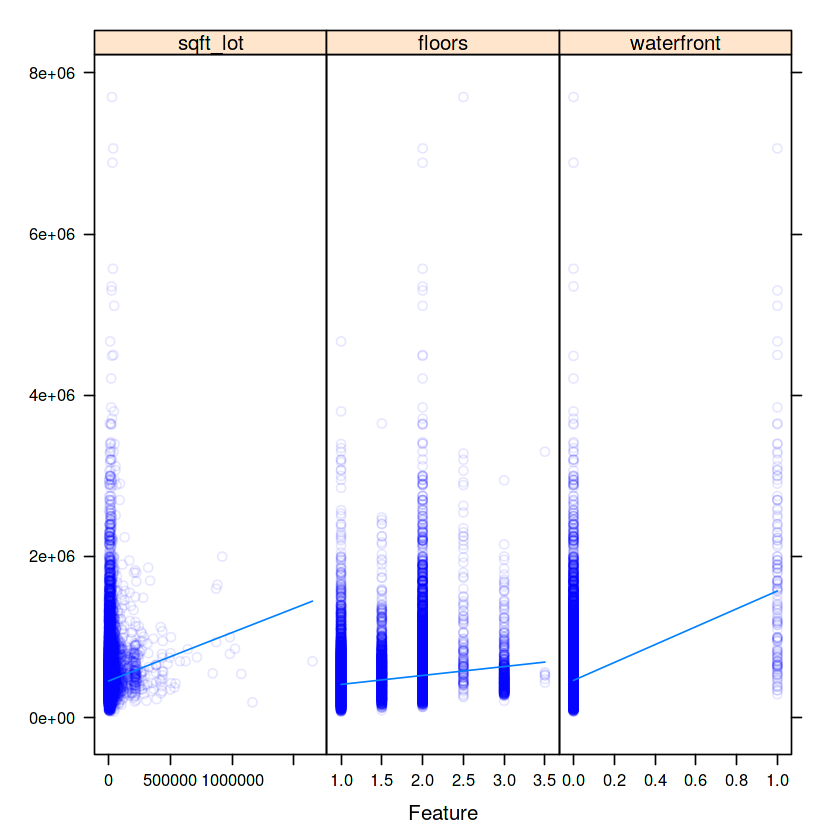

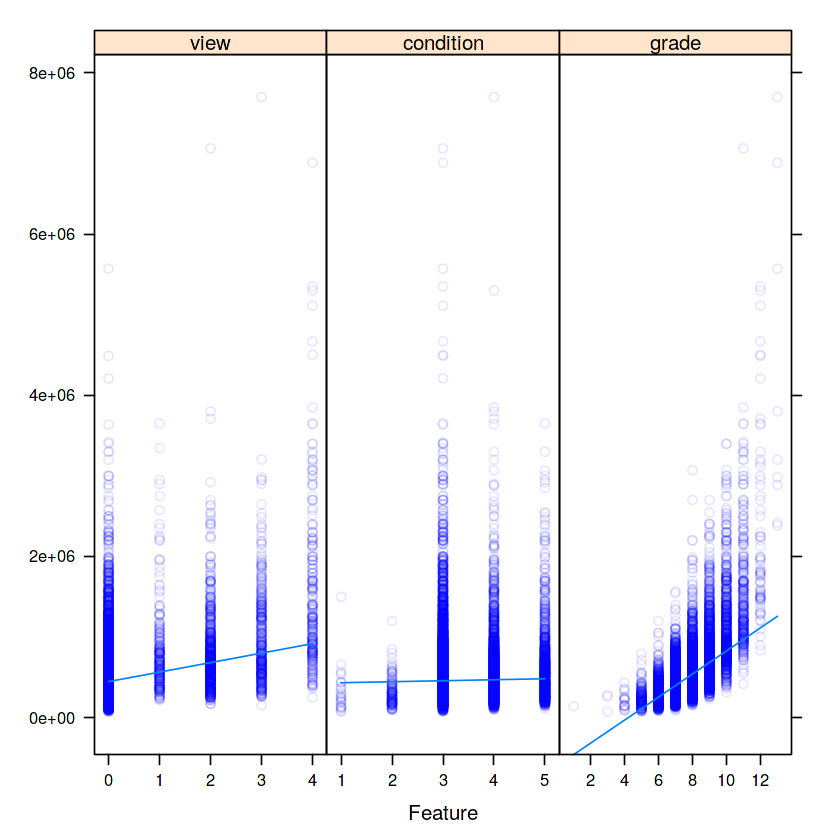

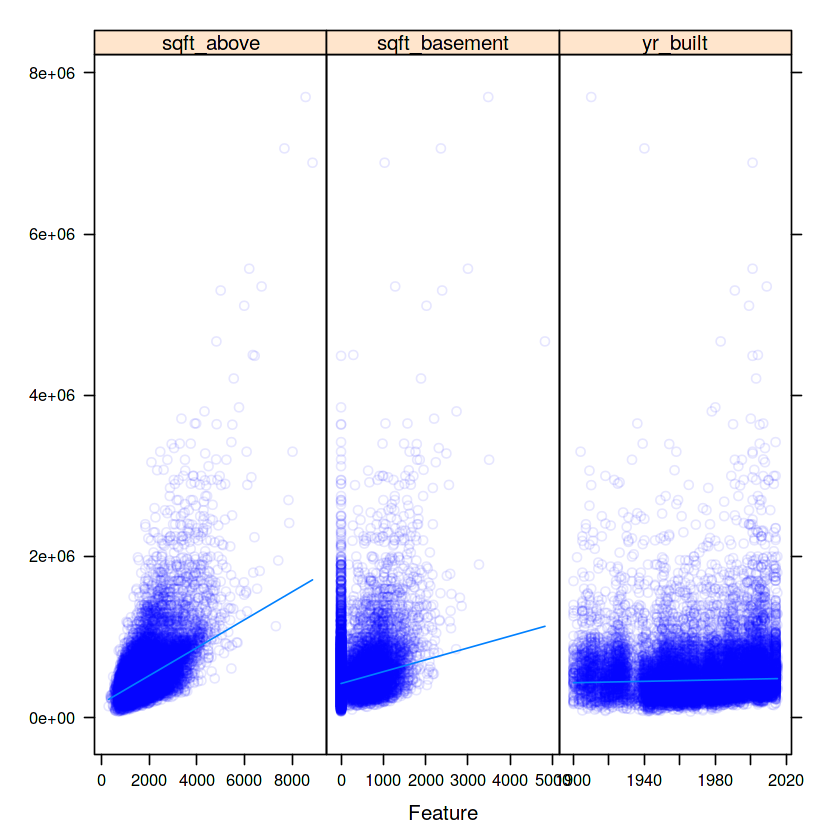

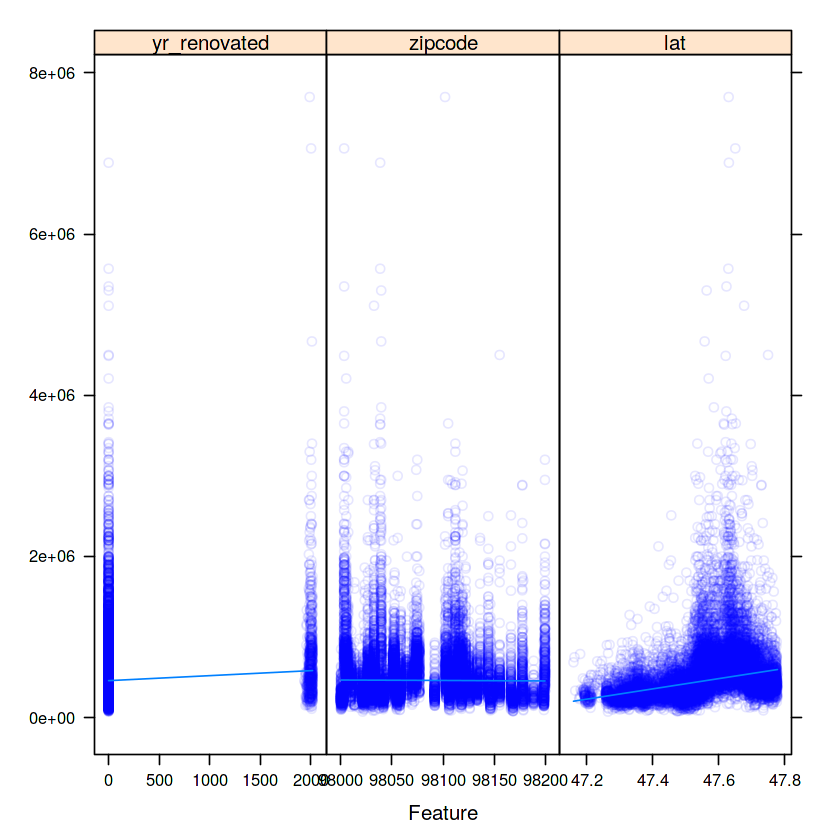

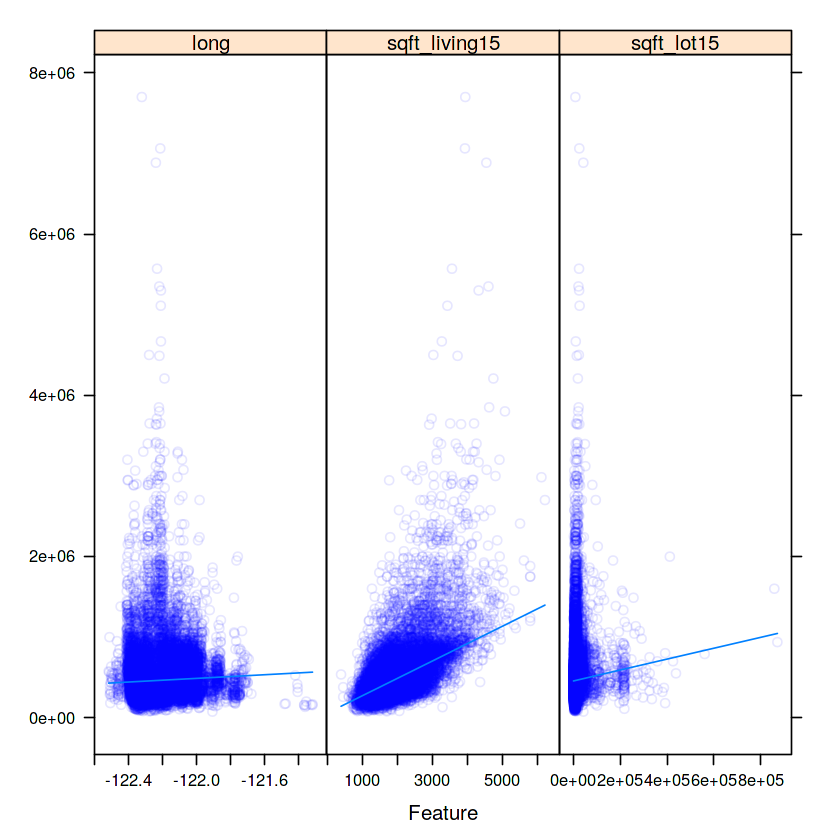

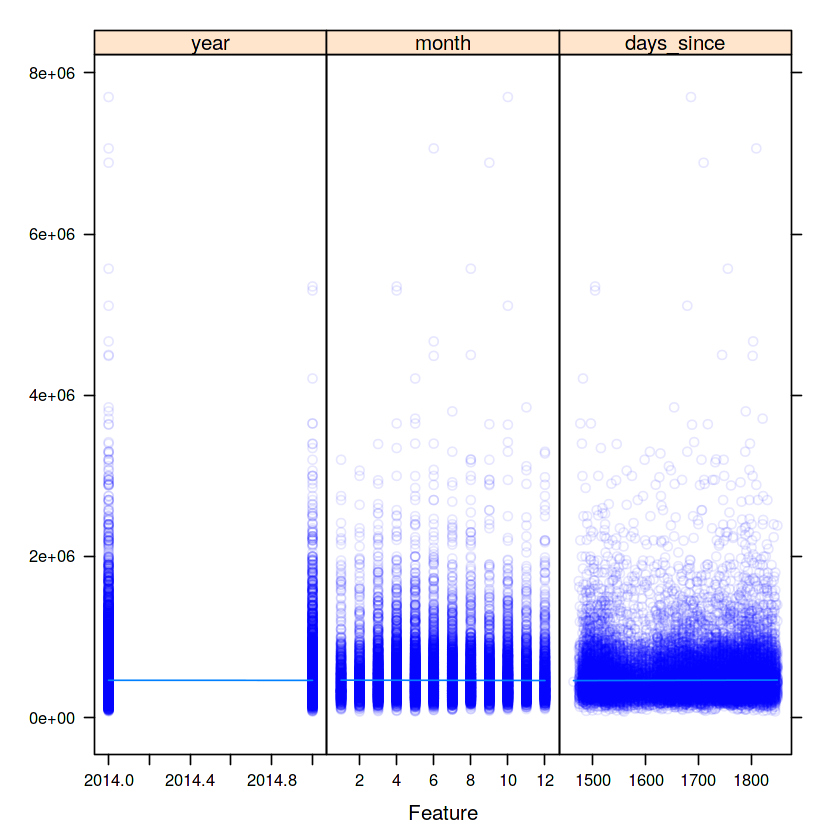

In [14]:
theme <- trellis.par.get()
theme$plot.symbol$col = "blue"
theme$plot.symbol$alpha = 0.1
trellis.par.set(theme)

featurePlot(x = train[, -"price"], y = train$price, plot = "scatter", type = c("p", "smooth"), span = 10, layout = c(3, 1))

### Feature values per level

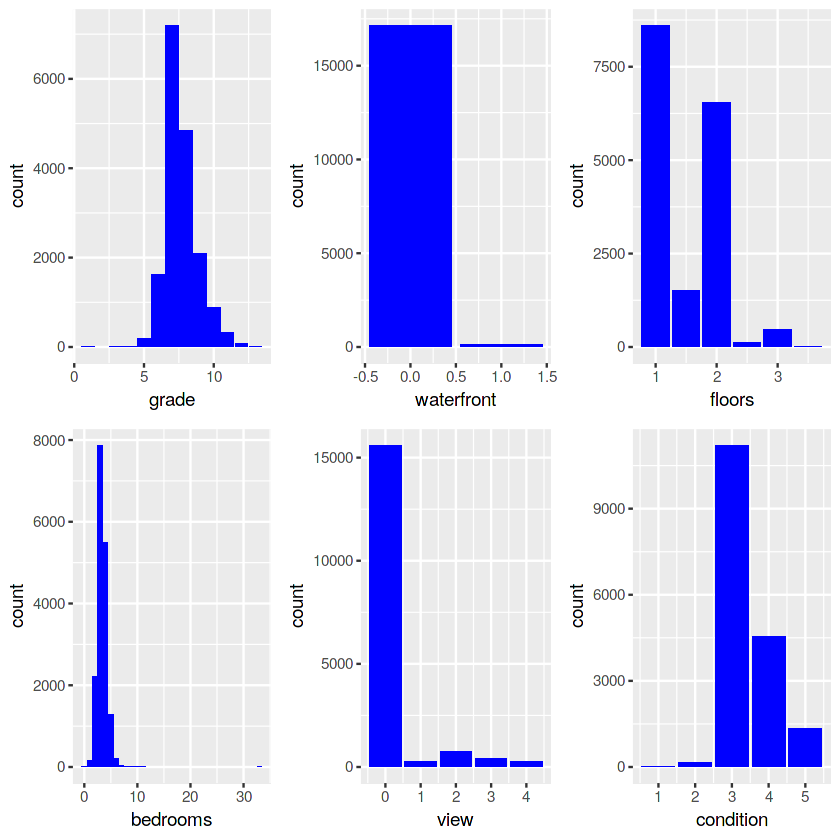

In [15]:
grade<-ggplot(train, aes(x=grade))+geom_bar(stat='count', fill = "blue")
waterfront<-ggplot(train, aes(x=waterfront))+geom_bar(stat='count', fill = "blue")
floors<-ggplot(train, aes(x=floors))+geom_bar(stat='count', fill = "blue")
bedrooms<-ggplot(train, aes(x=bedrooms))+geom_bar(stat='count', fill = "blue")
view<-ggplot(train, aes(x=view))+geom_bar(stat='count', fill = "blue")
condition<-ggplot(train, aes(x=condition))+geom_bar(stat='count', fill = "blue")
grid.arrange(grade, waterfront, floors, bedrooms, view, condition, ncol=3)

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has.

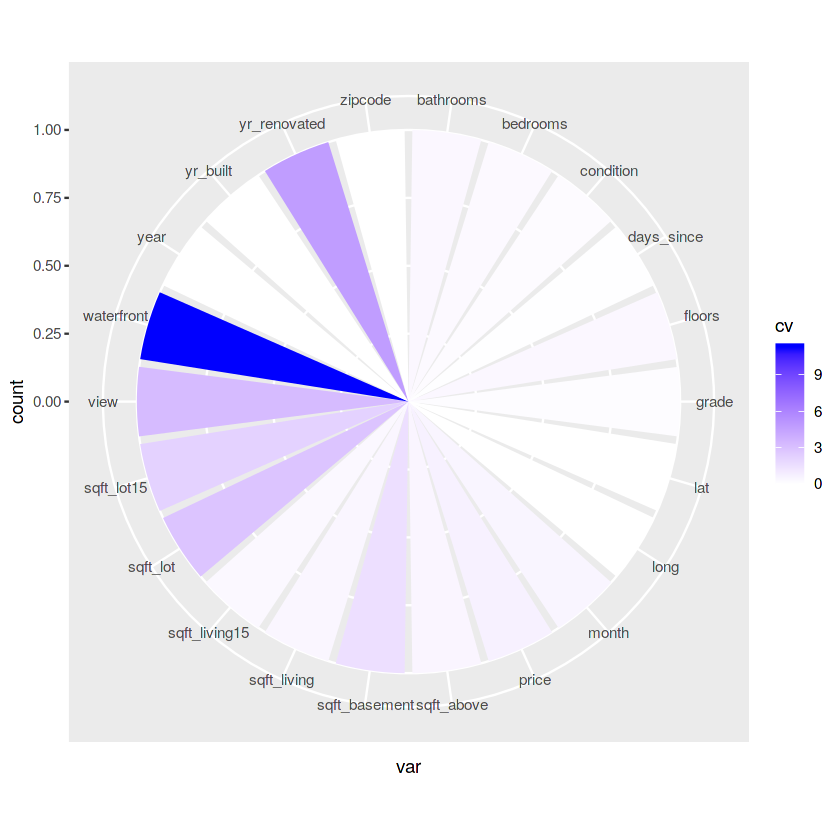

In [16]:
numeric_variables<-names(train)[sapply(train, is.numeric)]

sd_numeric_variables<-sapply(train[,numeric_variables, with=F], sd)
cv_numeric_variables<-sd_numeric_variables/colMeans(train[,numeric_variables, with=F])

ggplot(data.table(var=names(cv_numeric_variables),cv=cv_numeric_variables),
       aes(var,fill=cv))+geom_bar()+coord_polar()+scale_fill_gradient(low='white', high = 'blue')

Viewing variables with less than a 0.01 coefficient of variation

In [17]:
cv_numeric_variables[cv_numeric_variables < 0.01]

zipcode           lat          long          year 
 0.0005475842  0.0029120677 -0.0011499342  0.0002321521

### Boxplot of Numerical Variables

We review the distribution of numerical data through a boxplot for each variable that has a coefficient of variation higher than 0.4.

No id variables; using all as measure variables


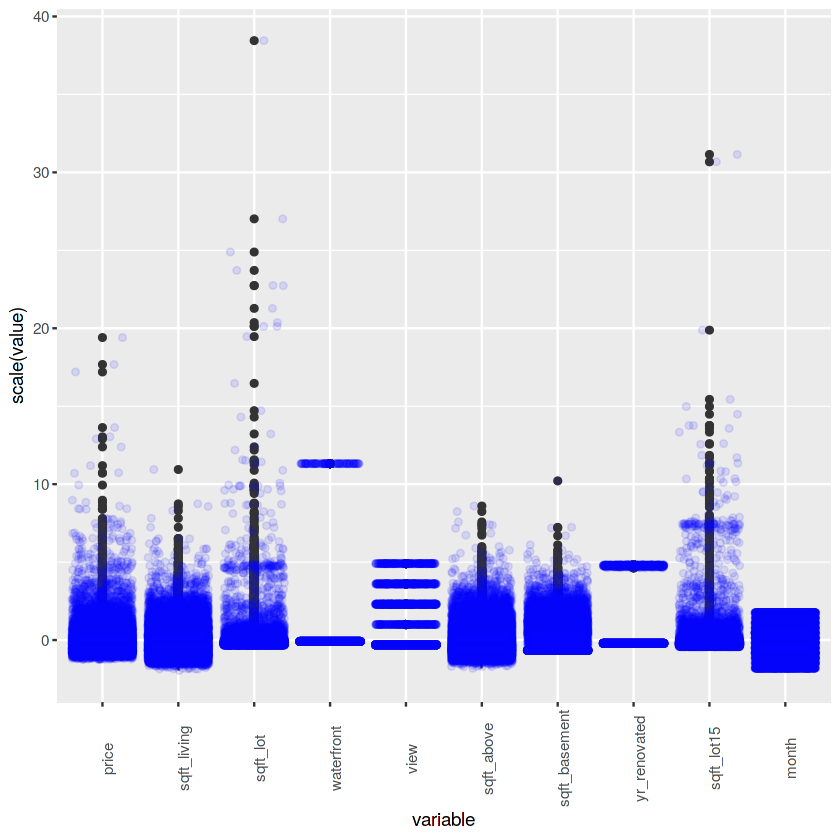

In [18]:
df<-train[, numeric_variables[cv_numeric_variables>0.4], with=F]
df<-data.frame(scale(df))
df<-melt(df)
       
ggplot(df, aes(x=variable, y=scale(value)))+geom_boxplot()+geom_jitter(alpha=.1, color="blue")+theme(axis.text.x = element_text(angle=90))

## Map of Apartments

In [19]:
centroid<-centroid(train[,c('long','lat')])
palette<-colorNumeric(palette = "plasma", domain = train$price)
map <- leaflet()
map <- addProviderTiles(map, "CartoDB.Positron")
map<-addCircles(map, lat =train$lat, lng =train$long, color=palette(train$price), fillOpacity = 1)
map<-addLegend(map, "bottomright", pal = palette, values = train$price, title = "House Prices", opacity = 1)
map<-setView(map, lng=centroid[1], lat=centroid[2], zoom = 11)
saveWidget(map, 'map.html')

In [20]:
display_html('<iframe src="map.html" width=1000, height=700></iframe>')

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns

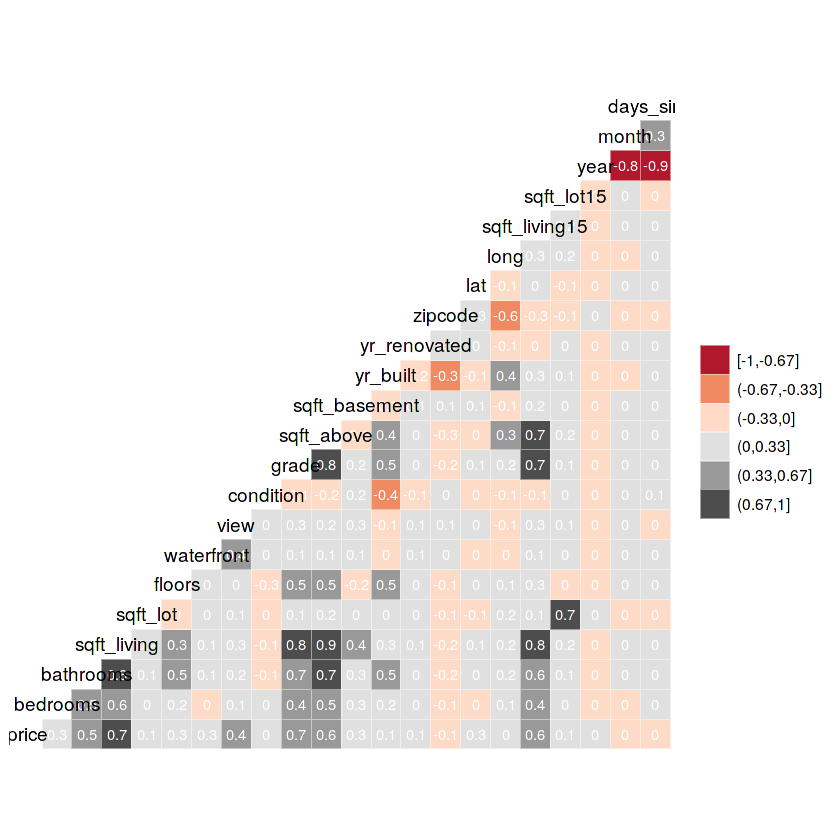

In [21]:
ggcorr(train, nbreaks=6, palette='RdGy', label=TRUE, label_size=3, label_color='white')

#### Subsetting correlations with a threshold of 85%

In [22]:
cor<-as.data.frame(as.table(cor(train)))
subset(cor, abs(Freq) > 0.85 & abs(Freq) < 1)

Var1        Var2        Freq      
77  sqft_above  sqft_living  0.8742446
224 sqft_living sqft_above   0.8742446
440 days_since  year        -0.8544209
482 year        days_since  -0.8544209

### Linear Dependencies

Caret uses QR decomposition to enumerate sets of linear combinations and therefore, remove them

In [23]:
lc<-findLinearCombos(train)
lc

$linearCombos
$linearCombos[[1]]
[1] 12  4 11


$remove
[1] 12

In [24]:
colnames(train[, 12])

[1] "sqft_basement"

## Baseline Construction

We will perform a baseline against which we will compare our feature engineering efforts to see if they improve the obtained results or not

### Defining Custom Metrics to Evaluate Models

The metric that we will use to tune our model will be the Mean Absolute Percentage Error (MAPE), therefore we need to add it to Caret as a custom metric

In [25]:
customMetrics <- function (data, lev = NULL, model = NULL) {
    c(
        MAPE = mean(abs(data$obs - data$pred)/data$obs),
        MAE = mean(abs(data$obs - data$pred)),
        RMSE = sqrt(mean((data$obs-data$pred)^2)),
        Rsquared = summary(lm(pred ~ obs, data))$r.squared
    )
}

### Defining Cross Validation Strategy

In [26]:
tc<-trainControl(
        method = "cv",
        number=5,
        savePredictions = TRUE,
        summaryFunction = customMetrics)

### Baseline Linear Regression

In [27]:
lm <- train(price~ ., data = train, method = "lm", trControl=tc)
lm$results

intercept MAPE      MAE      RMSE     Rsquared  MAPESD      MAESD    RMSESD
1 TRUE      0.2579186 126473.5 202225.5 0.7007212 0.003970009 917.6538 11249 
  RsquaredSD 
1 0.008444681

## Feature Engineering

A number of different combinations of feature engineering steps and transformations will be performed.

### Drop correlated, CV and linear combination features

Based on the features that were highly correlated, the ones that have a very low coefficient of variation and the ones that must be removed since they are linear combinations, we drop them from the datasets.

In [28]:
train[, c('sqft_above', 'sqft_basement', 'year'):=NULL]
test[, c('sqft_above', 'sqft_basement', 'year'):=NULL]

### Boroughs: Clustering On Location
We do a k-means cluster analysis based on the latitude and longitude of each house, the number of clusters was selected after careful selection to ensure a good distribution of houses in the different sets.

In [29]:
clusters <- kmeans(train[, c("lat", "long")], 12)
str(clusters)

List of 9
 $ cluster     : int [1:17292] 5 5 7 9 9 11 11 7 10 3 ...
 $ centers     : num [1:12, 1:2] 47.7 47.5 47.5 47.6 47.7 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:12] "1" "2" "3" "4" ...
  .. ..$ : chr [1:2] "lat" "long"
 $ totss       : num 673
 $ withinss    : num [1:12] 6.92 5.58 6.78 5.1 4.94 ...
 $ tot.withinss: num 59.4
 $ betweenss   : num 614
 $ size        : int [1:12] 1851 489 1892 1825 1953 1238 1823 204 1675 913 ...
 $ iter        : int 6
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


### Predicting Cluster for test set function

In [30]:
predict.kmeans <- function(object, newdata){
    centers <- object$centers
    n_centers <- nrow(centers)
    dist_mat <- as.matrix(dist(rbind(centers, newdata)))
    dist_mat <- dist_mat[-seq(n_centers), seq(n_centers)]
    max.col(-dist_mat)
}

In [31]:
train$borough <- as.factor(clusters$cluster)
test$borough <- as.factor(predict.kmeans(clusters, test[, c("lat", "long")]))

### Distance to centroid of map

Since we do not wish to have latitude and longituded as features, we instead calculate the distance of the house to the centroid of the map.

In [32]:
train$distance<-distm(centroid, train[,c('long','lat')], fun = distHaversine)
test$distance<-distm(centroid, test[,c('long','lat')], fun = distHaversine)

Warning message in `[<-.data.table`(x, j = name, value = value):
“17292 column matrix RHS of := will be treated as one vector”Warning message in `[<-.data.table`(x, j = name, value = value):
“4321 column matrix RHS of := will be treated as one vector”

### Setting up Preprocessing: Centering, Scaling and performing a Yeo Johnson transformation

To reduce the weight/importance of certain features due to their scale, we center them and scale them. We also reduce skewness by performing a Yeo Johnson transformation. This combination will be performed on each model training.

In [33]:
pp<-c("center", "scale", "YeoJohnson")
preProcess(train[,-"price"], method =pp)

Created from 17292 samples and 20 variables

Pre-processing:
  - centered (19)
  - ignored (1)
  - scaled (19)
  - Yeo-Johnson transformation (13)

Lambda estimates for Yeo-Johnson transformation:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.68427 -0.27014 -0.18991 -0.07719  0.39298  2.53215 


To reduce the weight/importance of certain features due to their scale, we center them and scale them.

## One Hot Encoding

Since we have multiple features that could be considered factors, we will try two approaches:

### Boroughs
We one hot encode the boroughs so that each possible value has a column assigned to it.

In [34]:
final<-train
test_copy<-test

dummy<-dummyVars(formula= ~., data = final[, -"price"], fullRank=T, sep = "_")
final<-data.table(predict(dummy, newdata = final[, -"price"]))
final$price<-train$price
test<-data.table(predict(dummy, newdata = test))
test$id<-test_copy$id
test$price<-test_copy$price
head(final)

bedrooms bathrooms sqft_living sqft_lot floors waterfront view condition
1 3        2.25      2570          7242   2      0          0    3        
2 2        1.00       770         10000   1      0          0    3        
3 4        3.00      1960          5000   1      0          0    5        
4 3        2.00      1680          8080   1      0          0    3        
5 4        4.50      5420        101930   1      0          0    3        
6 3        2.25      1715          6819   2      0          0    3        
  grade yr_built ⋯ borough_5 borough_6 borough_7 borough_8 borough_9 borough_10
1  7    1951     ⋯ 1         0         0         0         0         0         
2  6    1933     ⋯ 1         0         0         0         0         0         
3  7    1965     ⋯ 0         0         1         0         0         0         
4  8    1987     ⋯ 0         0         0         0         1         0         
5 11    2001     ⋯ 0         0         0         0         1         0         
6  7    1995     ⋯ 0         0         0         0         0         0         
  borough_11 borough_12 distance  price  
1 0          0          22411.653  538000
2 0          0          20559.302  180000
3 0          0          20894.456  604000
4 0          0           8012.786  510000
5 0          0          13230.842 1225000
6 1          0          32604.327  257500

### Grade, View, Condition and Boroughs
We one hot encode the boroughs but also the grade, view and condition of each apartment.

In [35]:
one_hot<-train
one_hot$grade <- as.factor(one_hot$grade)
one_hot$view <- as.factor(one_hot$view)
one_hot$condition <- as.factor(one_hot$condition)


dummy<-dummyVars(formula= ~., data = one_hot[, -"price"], fullRank=T, sep = "_")
one_hot<-data.table(predict(dummy, newdata = one_hot[, -"price"]))
one_hot$price<-train$price
head(one_hot)

bedrooms bathrooms sqft_living sqft_lot floors waterfront view_1 view_2
1 3        2.25      2570          7242   2      0          0      0     
2 2        1.00       770         10000   1      0          0      0     
3 4        3.00      1960          5000   1      0          0      0     
4 3        2.00      1680          8080   1      0          0      0     
5 4        4.50      5420        101930   1      0          0      0     
6 3        2.25      1715          6819   2      0          0      0     
  view_3 view_4 ⋯ borough_5 borough_6 borough_7 borough_8 borough_9 borough_10
1 0      0      ⋯ 1         0         0         0         0         0         
2 0      0      ⋯ 1         0         0         0         0         0         
3 0      0      ⋯ 0         0         1         0         0         0         
4 0      0      ⋯ 0         0         0         0         1         0         
5 0      0      ⋯ 0         0         0         0         1         0         
6 0      0      ⋯ 0         0         0         0         0         0         
  borough_11 borough_12 distance  price  
1 0          0          22411.653  538000
2 0          0          20559.302  180000
3 0          0          20894.456  604000
4 0          0           8012.786  510000
5 0          0          13230.842 1225000
6 1          0          32604.327  257500

### Dropping final unneeded features

In [36]:
final[, c('zipcode', 'lat', 'long'):=NULL]
one_hot[, c('zipcode', 'lat', 'long'):=NULL]
test[, c('zipcode', 'lat', 'long'):=NULL]

## Modeling

After the previous feature engineering steps, different models will be cross validated to accurately review the performance of it.

### Linear Regression with One Hot Encoded Boroughs, Grade, View and Condition
After our baseline, now we will try a linear regression again, this time with one hot encoded features.

In [37]:
ini<-now()
lm <- train(price~ ., data = one_hot, method = "lm", trControl=tc, preProcess=pp)
print(now()-ini)
lm$results

Time difference of 24.96736 secs


intercept MAPE      MAE      RMSE     Rsquared  MAPESD      MAESD    RMSESD  
1 TRUE      0.2275289 111006.4 183074.9 0.7555252 0.002836479 2830.629 12003.85
  RsquaredSD
1 0.01582151

### Random Forest with One Hot Encoded Boroughs
Now we try a random forest with one hot encoded boroughs only.

In [38]:
ini<-now()
rf <- train(price~ ., data = final, method = "ranger", trControl=tc, importance = "impurity", preProcess=pp)
print(now()-ini)
rf$results

Growing trees.. Progress: 87%. Estimated remaining time: 4 seconds.
Time difference of 13.9931 mins


mtry min.node.size splitrule  MAPE      MAE       RMSE     Rsquared 
1  2   5             variance   0.2026692  98012.86 176024.3 0.8154834
2  2   5             extratrees 0.2506066 116654.44 201129.3 0.8008405
3 14   5             variance   0.1511731  78811.54 143852.2 0.8510920
4 14   5             extratrees 0.1498619  77835.05 142894.2 0.8538775
5 27   5             variance   0.1517322  79795.46 146015.0 0.8447023
6 27   5             extratrees 0.1476991  76870.31 140837.1 0.8567907
  MAPESD      MAESD     RMSESD   RsquaredSD 
1 0.002914757 1639.0168 8621.482 0.015315110
2 0.004977410 1960.9981 6673.135 0.008724044
3 0.001818609  925.7656 6230.494 0.010580787
4 0.002338817 1320.9417 5469.011 0.008367874
5 0.002348565  941.3091 5836.627 0.011374171
6 0.001855838 1121.5487 5409.925 0.009333008

### Random Forest with One Hot Encoded Boroughs, Grade, View and Condition
Now we try a random forest with one hot encoded features to see which one performs better.

In [39]:
ini<-now()
dummy_rf <- train(price~ ., data = one_hot, method = "ranger", trControl=tc, importance = "impurity", preProcess=pp)
print(now()-ini)
dummy_rf$results

Growing trees.. Progress: 53%. Estimated remaining time: 27 seconds.
Time difference of 23.67565 mins


mtry min.node.size splitrule  MAPE      MAE       RMSE     Rsquared 
1  2   5             variance   0.2498496 116219.43 200374.4 0.7785954
2  2   5             extratrees 0.2787159 127290.77 215475.2 0.7674644
3 22   5             variance   0.1531649  79644.84 145615.4 0.8477479
4 22   5             extratrees 0.1518626  79601.79 148528.2 0.8404074
5 43   5             variance   0.1534421  80468.36 148177.7 0.8400986
6 43   5             extratrees 0.1488331  77939.60 144787.0 0.8478622
  MAPESD      MAESD     RMSESD   RsquaredSD
1 0.004957922 1703.3330 7168.588 0.02339257
2 0.004239693  994.4151 6765.164 0.01952943
3 0.004580484 2621.2692 7327.344 0.01713239
4 0.005006892 2260.8225 6291.518 0.01548647
5 0.004908561 2690.4632 6966.228 0.01771276
6 0.005494757 2703.0507 7086.868 0.01793327

### XGBoost with One Hot Encoded Boroughs
Now we try an xgb with one hot encoded boroughs only.

In [40]:
ini<-now()
xgb <- train(price~ ., data = final, method = "xgbTree", trControl=tc, importance = TRUE, preProcess=pp)
print(now()-ini)
tail(xgb$results)

Time difference of 47.80664 mins


eta max_depth gamma colsample_bytree min_child_weight subsample nrounds
93  0.4 3         0     0.6              1                0.50      150    
96  0.4 3         0     0.6              1                0.75      150    
99  0.4 3         0     0.6              1                1.00      150    
102 0.4 3         0     0.8              1                0.50      150    
105 0.4 3         0     0.8              1                0.75      150    
108 0.4 3         0     0.8              1                1.00      150    
    MAPE      MAE      RMSE     Rsquared  MAPESD      MAESD    RMSESD   
93  0.1669886 87157.92 151761.2 0.8308217 0.006189669 4527.980 17043.521
96  0.1588526 83042.89 146359.0 0.8434874 0.004043967 2578.538 10289.165
99  0.1571691 81836.78 142055.0 0.8518738 0.003941018 2221.869  9715.849
102 0.1659406 86585.95 150681.9 0.8334639 0.004970728 2836.294 12866.049
105 0.1594920 82908.22 144109.8 0.8477015 0.004335013 3245.064 13764.903
108 0.1536090 80298.74 139761.8 0.8561808 0.003322823 1625.003  6339.712
    RsquaredSD 
93  0.022775843
96  0.007433320
99  0.010171517
102 0.014523247
105 0.014720896
108 0.004698004

### XGBoost with One Hot Encoded Boroughs, Grade, View and Condition
Now we try an xgb with one hot encoded features to see which one performs better.

In [41]:
ini<-now()
dummy_xgb <- train(price~ ., data = one_hot, method = "xgbTree", trControl=tc, importance = TRUE, preProcess=pp)
print(now()-ini)
tail(dummy_xgb$results)

Time difference of 48.64616 mins


eta max_depth gamma colsample_bytree min_child_weight subsample nrounds
93  0.4 3         0     0.6              1                0.50      150    
96  0.4 3         0     0.6              1                0.75      150    
99  0.4 3         0     0.6              1                1.00      150    
102 0.4 3         0     0.8              1                0.50      150    
105 0.4 3         0     0.8              1                0.75      150    
108 0.4 3         0     0.8              1                1.00      150    
    MAPE      MAE      RMSE     Rsquared  MAPESD      MAESD    RMSESD  
93  0.1672336 86962.99 150792.7 0.8349768 0.003987735 1448.248 6045.233
96  0.1599168 82846.43 144218.6 0.8498901 0.003543461 1568.712 8949.166
99  0.1588959 83061.71 145973.8 0.8453811 0.004051367 1926.699 6450.439
102 0.1666219 86120.77 150790.1 0.8369713 0.004473594 1744.535 9276.385
105 0.1611925 83764.39 145467.9 0.8467117 0.004745386 2730.671 6977.354
108 0.1545944 80876.03 143737.7 0.8512296 0.004284106 2376.587 9804.172
    RsquaredSD 
93  0.003105919
96  0.013768930
99  0.007117242
102 0.017381813
105 0.009787123
108 0.012984296

## Scores: Comparing Models
### Importances: LM, RF, ONE HOT RF, ONE HOT XGB

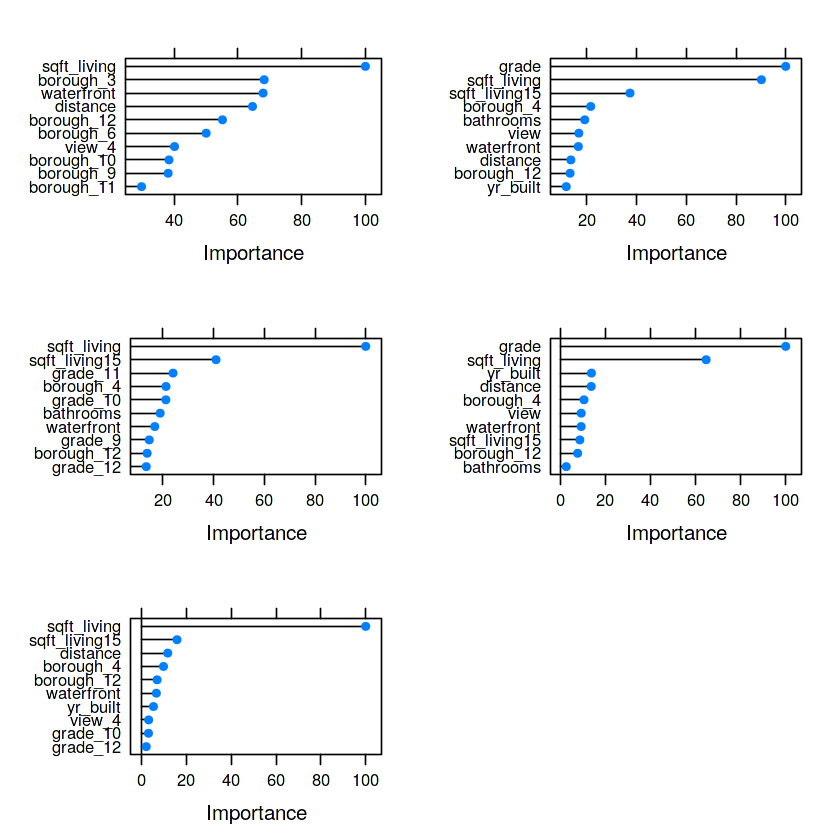

In [42]:
lmplot<-plot(varImp(lm), top = 10)
rfplot<-plot(varImp(rf), top = 10)
dummyrfplot<-plot(varImp(dummy_rf), top = 10)
xgbplot<-plot(varImp(xgb), top = 10)
dummyxgbplot<-plot(varImp(dummy_xgb), top = 10)
grid.arrange(lmplot, rfplot, dummyrfplot, xgbplot, dummyxgbplot, ncol=2)

### Metric Results

In [43]:
results <- resamples(list(
    LM = lm,
    RF = rf,
    DRF = dummy_rf,
    XGB = xgb,
    DXGB = dummy_xgb),
)

summary(results)


Call:
summary.resamples(object = results)

Models: LM, RF, DRF, XGB, DXGB 
Number of resamples: 5 

MAE 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM   107215.25 110523.39 110825.18 111006.36 111299.25 115168.75    0
RF    75647.61  76620.30  76630.53  76870.31  76739.07  78714.02    0
DRF   74625.71  76810.06  76903.45  77939.60  80015.34  81343.41    0
XGB   78854.50  79071.27  79774.89  80298.74  81004.96  82788.09    0
DXGB  78399.54  80619.32  80727.18  81061.67  81256.68  84305.64    0

MAPE 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM   0.2250103 0.2251607 0.2268419 0.2275289 0.2288623 0.2317693    0
RF   0.1446302 0.1476228 0.1482263 0.1476991 0.1484394 0.1495769    0
DRF  0.1430043 0.1444140 0.1490260 0.1488331 0.1509733 0.1567482    0
XGB  0.1480214 0.1538817 0.1545096 0.1536090 0.1547405 0.1568920    0
DXGB 0.1505005 0.1549433 0.1584217 0.1569610 0.1604262 0.1605130    0

RMSE 
         Min.  1st Qu.   Median     Mean

### Plots of Results

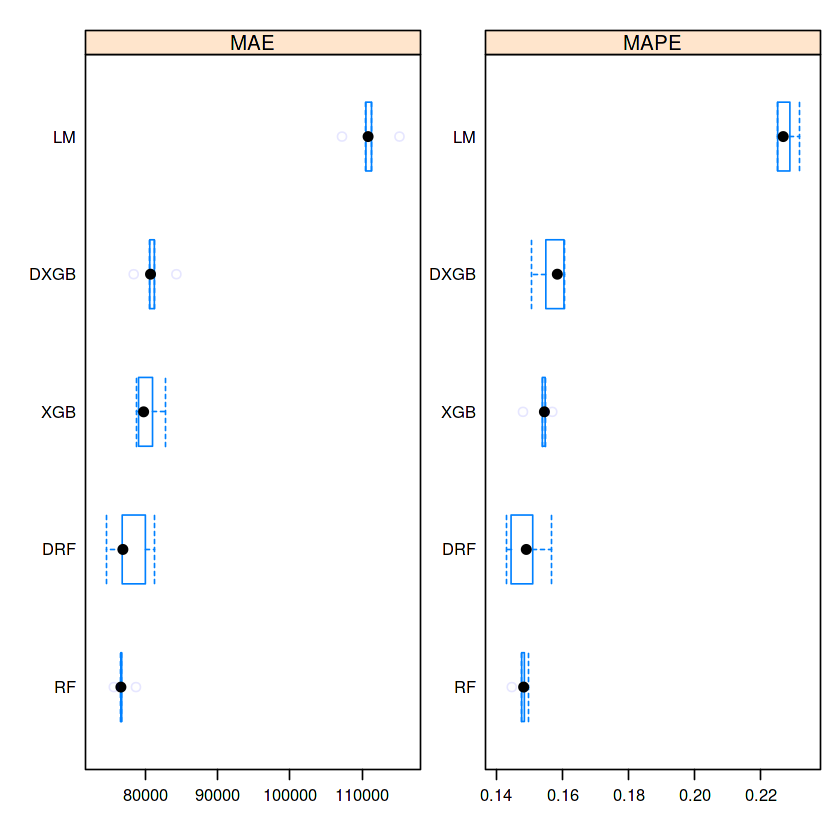

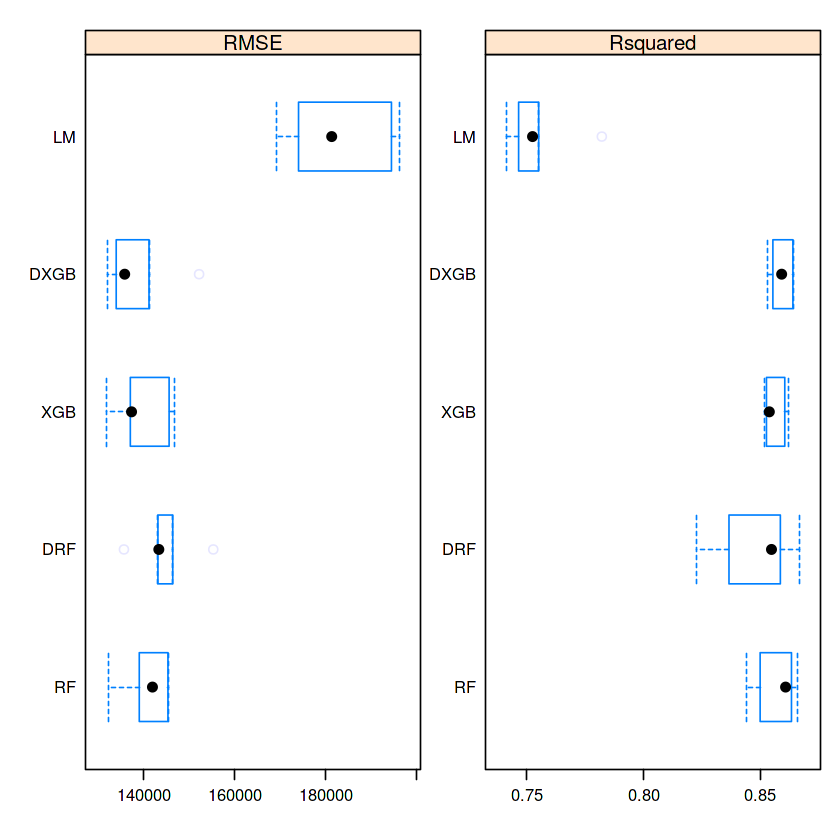

In [44]:
bwplot(results, layout = c(2, 1), scales = list(relation="free"))

Finally, we choose a normal random forest on processed data, without one hot encoding

## Hyperparameter Tuning Through Repeated Cross Validated Randomized Grid Search

Finally we perform a cross validated, randomized grid search on the chosen random forest in order to define the final model, the chosen one will be the one with the smallest MAPE.

In [45]:
grid<-expand.grid(
    mtry=c(22,27),
    splitrule=c('extratrees'),
    min.node.size=c(3,5,8)
)

tc<-trainControl(
    method = "repeatedcv",
    number=5,
    repeats = 2,
    savePredictions = TRUE,
    summaryFunction = customMetrics,
    search = "random"
)

ini<-now()

grid_rf <- train(
    price ~ .,
    data = final,
    method = "ranger",
    num.trees=500,
    maximize=FALSE,
    tuneGrid = grid,
    trControl = tc,
    metric = "MAPE",
    tuneLength = 5,
    verbose = TRUE
)

print(now()-ini)

grid_rf

Growing trees.. Progress: 83%. Estimated remaining time: 6 seconds.
Time difference of 32.02912 mins


Random Forest 

17292 samples
   27 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 13833, 13832, 13834, 13836, 13833, 13833, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  MAPE       MAE       RMSE      Rsquared 
  22    3              0.1477603  77042.22  141519.2  0.8559461
  22    5              0.1480252  77178.81  141866.3  0.8554018
  22    8              0.1489082  77624.27  142494.7  0.8541338
  27    3              0.1472957  76917.19  141283.0  0.8561615
  27    5              0.1476724  77033.02  141436.2  0.8558705
  27    8              0.1483511  77417.38  142105.7  0.8545013

Tuning parameter 'splitrule' was held constant at a value of extratrees
MAPE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 27, splitrule = extratrees
 and min.node.size = 3.

In [46]:
grid_rf$bestTune

mtry splitrule  min.node.size
4 27   extratrees 3

In [47]:
grid_rf$finalModel

Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = min(param$mtry, ncol(x)), min.node.size = param$min.node.size,      splitrule = as.character(param$splitrule), write.forest = TRUE,      probability = classProbs, ...) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      17292 
Number of independent variables:  27 
Mtry:                             27 
Target node size:                 3 
Variable importance mode:         none 
Splitrule:                        extratrees 
OOB prediction error (MSE):       19722796994 
R squared (OOB):                  0.8551347 

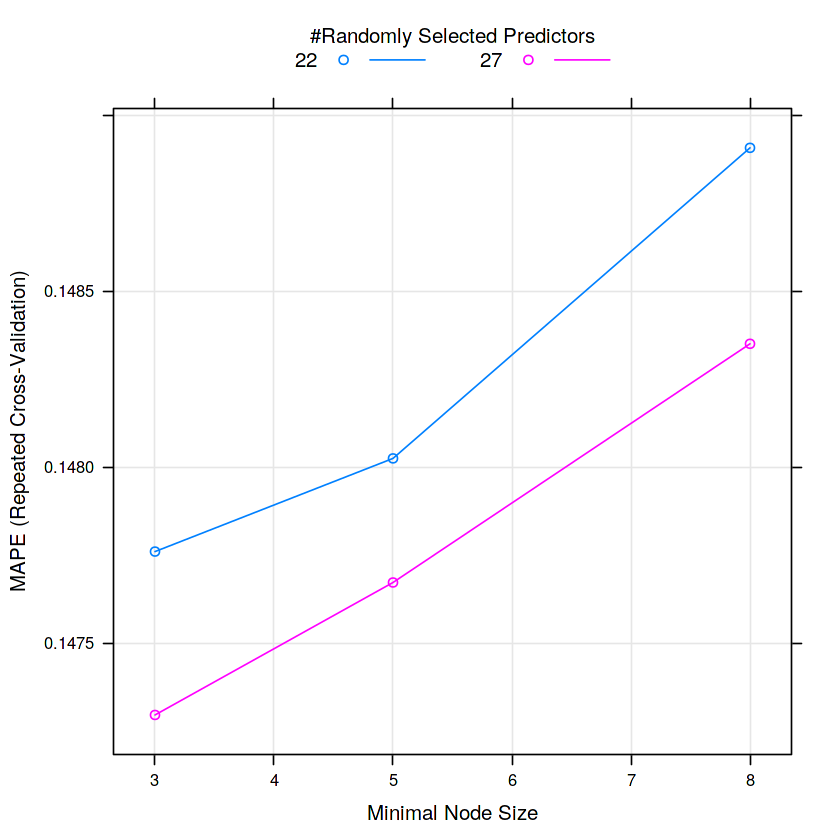

In [48]:
plot(grid_rf)

## Predicting
We predict on the test set, add the predictions to it and create our predictions file.

In [49]:
predicted <- predict(grid_rf, newdata = test[,-c("id","price")])
df_pred<-cbind(test, predicted)

### Final Mean Absolute Percentage Error (MAPE) Results

In [50]:
mean(abs((test$price-predicted)/test$price) * 100)

[1] 14.57111

### Final R^2 Score

In [51]:
cor(test$price, predicted) ^ 2

[1] 0.8485847

### Plot of Results

Here we plot the predicted price against the actual price, the closer the values are to a diagonal line the better the predictions.

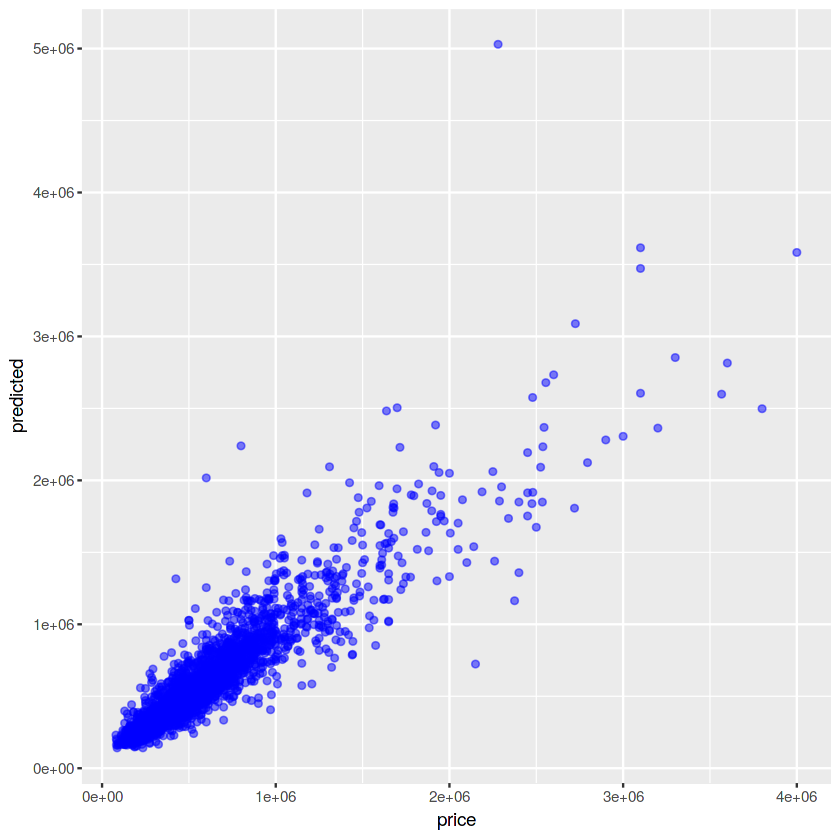

In [52]:
ggplot(df_pred, aes(price, predicted)) + geom_point(color="blue", alpha=0.5)

## Conclusions
After careful exploratory analysis, we were able to perform multiple feature engineering steps that increased the performance of our models, from them, we were able to choose one model in order to perform a randomized repeated and cross validated grid search in order to tune it to our data, finally, we were able to predict our testing dataset based on this entire process.

It must be noted that performing feature engineering is one of the most important steps in the process, working with metrics like latitude and longitude can sometimes complicate things, that is why we must find ways to extract that information so that the different models can use it and take advantage of it.

Overall, our final results are very satisfactory, which gives us the confidence that we have created a good model that can accurately estimate the prices of different houses. The uses of a model like this are countless and it will surely help the relevant stakeholders to make better decisions.

In [53]:
stopCluster(cluster)